<a href="https://colab.research.google.com/github/Viswanth13/SentimentAnalysis_VT/blob/main/SentimentAnalysisVT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi Modal Sentiment and Emotional Analytics

In [1]:
import os
import zipfile

# Extract dataset
zip_path = "/content/fer2013.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("fer2013")

# Confirm extraction
print("Extracted files:", os.listdir("fer2013"))


Extracted files: ['test', 'train']


In [2]:
# Extract dataset
zip_path = "/content/sentiment140.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("sentiment140")

# Confirm extraction
print("Extracted files:", os.listdir("sentiment140"))

Extracted files: ['training.1600000.processed.noemoticon.csv']


In [3]:
import pandas as pd
import re
import string

# Load Sentiment140 dataset
csv_path = "/content/sentiment140/training.1600000.processed.noemoticon.csv"
df = pd.read_csv(csv_path, encoding='ISO-8859-1', header=None)



In [4]:
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
df.columns = ["sentiment", "id", "date", "query", "user", "text"]
df = df[["sentiment", "text"]]  # Keep relevant columns

# Convert sentiment labels (0 → Negative, 4 → Positive)
df["sentiment"] = df["sentiment"].replace({0: "Negative", 4: "Positive"})


In [6]:
# Clean text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    return text

df["clean_text"] = df["text"].apply(clean_text)
df.head()


,sentiment,text,clean_text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot awww thats a bummer you shoulda ...
1,Negative,is upset that he can't update his Facebook by ...,is upset that he cant update his facebook by t...
2,Negative,@Kenichan I dived many times for the ball. Man...,kenichan i dived many times for the ball manag...
3,Negative,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all....",nationwideclass no its not behaving at all im ...


Available images: ['Training_34273117.jpg', 'Training_36141209.jpg', 'Training_3216904.jpg', 'Training_33279912.jpg', 'Training_7294820.jpg']


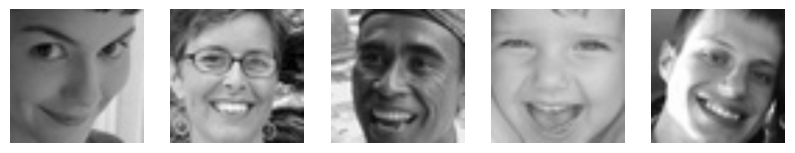

In [7]:
import os
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Define image path
image_folder = "/content/fer2013/train/happy"

# Confirm image path
if os.path.exists(image_folder):
    print("Available images:", os.listdir(image_folder)[:5])  # Show some file names
else:
    print("Error: Image folder not found!")

# Load images
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png'))][:10]

# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Apply transformation
images = [transform(Image.open(img)) for img in image_files]

# Display images
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i, img in enumerate(images[:5]):
    axes[i].imshow(img.permute(1, 2, 0).numpy())
    axes[i].axis("off")
plt.show()


In [15]:
# Emotion Classification using pre trained CNN
import torch
from torchvision import models, transforms
from PIL import Image

# 1. Load ResNet18 with FER2013-compatible modifications
model = models.resnet18(pretrained = True)  # Start with untrained weights
# Adjust the final fully connected layer for 7 classes (FER2017)
model.fc = torch.nn.Linear(model.fc.in_features, 7)
model.eval()

# 3. Define transformations matching your training preprocessing
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # ResNet expects 3 channels
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# 4. Predict on a single example image
image = Image.open("fer2013/test/happy/PrivateTest_10470092.jpg")
image = transform(image).unsqueeze(0)  # Add batch dimension

with torch.no_grad():
    output = model(image)
    prediction = torch.argmax(output, dim=1).item()

# 5. Map prediction to emotion
emotions = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
print("Predicted Emotion:", emotions[prediction])


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Predicted Emotion: Happy


In [19]:
# Text Sentiment Analysis with Hugging Face

from transformers import pipeline

# Load a Twitter-specific model (3-class: negative, neutral, positive)
classifier = pipeline(
    "sentiment-analysis",
)

batch_size = 128
df_sample = df.sample(n=10_000, random_state=42).copy()
predictions = classifier(df_sample["clean_text"].tolist(), batch_size=128)

# Extract labels and scores
df_sample["predicted_label"] = [pred["label"].lower() for pred in predictions]
df_sample["confidence"] = [pred["score"] for pred in predictions]



No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0


In [20]:
df_sample.head()

,sentiment,text,clean_text,predicted_label,confidence
541200,Negative,@chrishasboobs AHHH I HOPE YOUR OK!!!,chrishasboobs ahhh i hope your ok,positive,0.996594
750,Negative,"@misstoriblack cool , i have no tweet apps fo...",misstoriblack cool i have no tweet apps for ...,positive,0.983419
766711,Negative,@TiannaChaos i know just family drama. its la...,tiannachaos i know just family drama its lame...,negative,0.995727
285055,Negative,School email won't open and I have geography ...,school email wont open and i have geography s...,negative,0.963292
705995,Negative,upper airways problem,upper airways problem,negative,0.999022
